##### Modelo SEIR (Susceptibles, Expuestos, Infectados, Recuperados, Fallecidos) + Detectados

In [1]:
import numpy as np
import scipy
import scipy.integrate
import lmfit

from utilidades import *

def seir_model(SEIR, beta, sigma, gamma, mu, theta=0, beta_d=0):
    S, E, I, D, R, F = SEIR

    # Poblacion
    N = S + E + I + D + R

    # - Los susceptibles que pasan a expuestos a razon `beta` (infectados no detectados)
    # - Los susceptibles que pasan a expuestos a razon `beta_d` (infectados detectados)
    dS = - beta * S * I / N - beta_d * S * D / N
    # + Los susceptibles que pasan a expuestos a razon `beta` (infectados no detectados)
    # + Los susceptibles que pasan a expuestos a razon `beta_d` (infectados detectados)
    # - Los expuestos que pasan a infectados a razon `sigma`
    dE = beta * S * I / N + beta_d * S * D / N - sigma * E
    # + Los expuestos que pasan a infectados no detectados a razon `sigma`
    # - Los infectados no detectados que pasan a recuperados a razon `gamma`
    # - Los infectados no detectados que pasan a fallecidos a razon `mu`
    # - Los infectados no detectados que pasan a detectados a razon `theta`
    dI = sigma * E - gamma * I - mu * I - theta * I
    # + Los infectados no detectados que pasan a detectados a razon `theta`
    # - Los detectados que pasan a recuperados a razon `gamma`
    # - Los detectados que pasan a fallecidos a razon `mu`
    dD = theta * I - gamma * D - mu * D
    # + Los infectados no detectados que pasan a recuperados a razon `gamma`
    # + Los detectados que pasan a recuperados a razon `gamma`
    dR = gamma * I + gamma * D
    # + Los infectados no detectados que pasan a fallecidos a razon `mu`
    # + Los detectados que pasan a fallecidos a razon `mu`
    dF = mu * I + mu * D

    return [
        dS, dE, dI, dD, dR, dF
    ]

Clases:
    * Susceptible
    * Expuesto
    * Infectado
    * Recuperado
    * Fallecido
Nueva Clase:
    * Detectado
    
Parametros:  
    * `beta` es la razon de transmision  
    * `sigma` es la razon de transicion de Expuesto a Infectado  
    * `gamma` es la razon de transicion de Infectado a Recuperado (o aislado)  
    * `mu` es la razon de transicion de Infectado a Fallecido
Nuevos Parametros:  
    * `theta` es la razon de transicion de Infectado a Detectado  
    * `beta_d` es la razon de transmision de los Detectados  


In [2]:
periodo_incubacion = 5.2
periodo_infeccioso = 12.4
razon_mortalidad = 3.4 / 100.0 # OMS, best fit

infectados_t0 = 16.

susceptibles_t0 = 11e6

data = load_data()

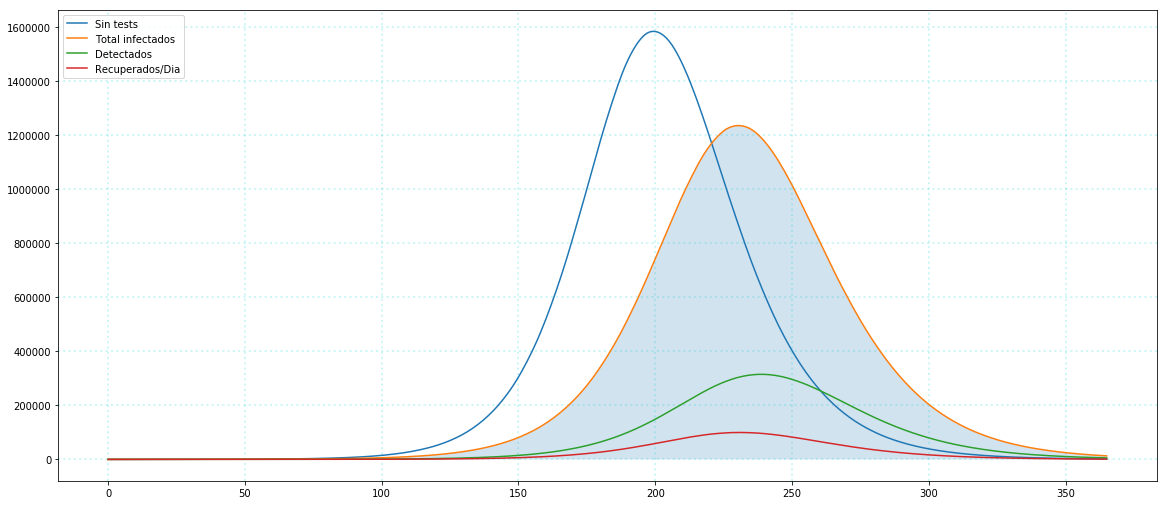

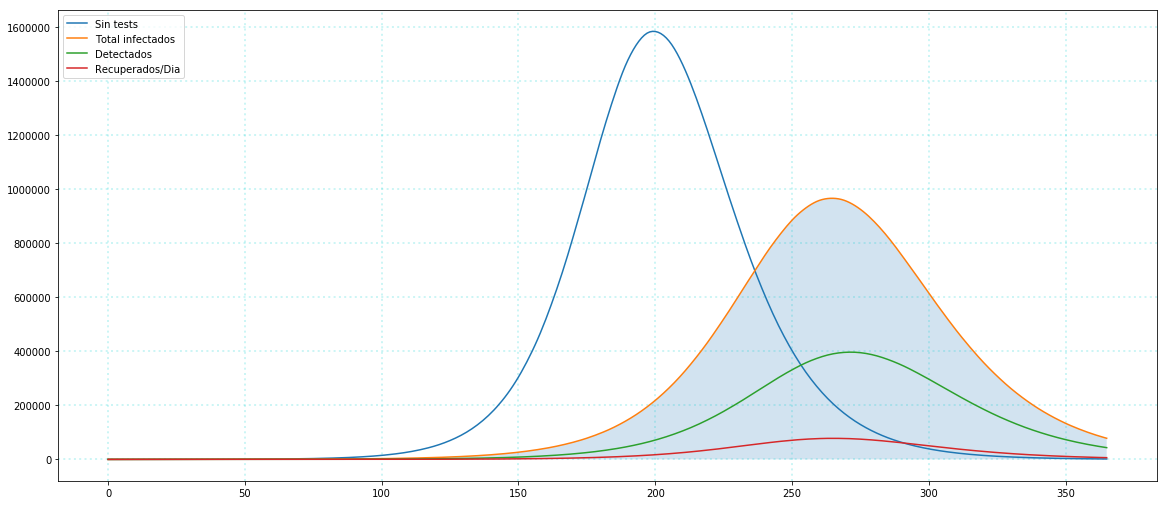

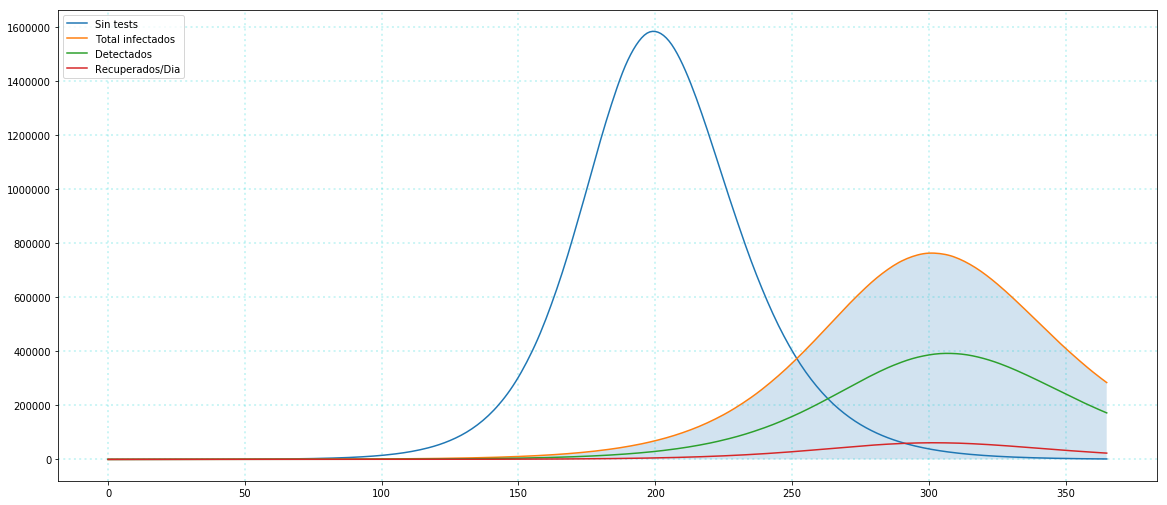

In [10]:
def run_model(params):
    if type(params) == lmfit.Parameters:
        params = [param.value for param in params.values()]
        
    R0, theta_t0, theta_t1, R_D = params
    
    SEIR_t0 = (
        susceptibles_t0,
        infectados_t0 * R0,
        infectados_t0,
        0, 0, 0
    )
    return run(
        seir_model,
        SEIR_t0,
        beta = R0 / periodo_infeccioso,
        sigma = 1. / periodo_incubacion,
        gamma = 1. / periodo_infeccioso,
        mu = razon_mortalidad / periodo_infeccioso,
        theta = [theta_t0, theta_t0, theta_t1],
        beta_d = R_D / periodo_infeccioso,
        days = days,
        step = 1
    )

days = [23, 365 - 23]

solutions = [
    (theta, run_model((2.4, theta, theta, 1.))) for theta in (
        np.arange(start=0., stop=0.1, step=0.03)
    )
]

solutions_x = solutions[0][1]['t']
solutions = [(theta, sol['y'][3], sol['y'][3] + sol['y'][2], sol['y'][4]) for theta, sol in solutions]
theta, sol_d, sol_it, sol_r = zip(*solutions)
sol_r = [np.diff(_, prepend=[_[0]]) for _ in sol_r]

for _ in range(1, len(solutions)):
    ax = plot(solutions_x, sol_it[0], labels=['Sin tests'])
    ax.plot(solutions_x, sol_it[_], label='Total infectados')
    ax.plot(solutions_x, sol_d[_], label='Detectados')
    ax.plot(solutions_x, sol_r[_], label='Recuperados/Dia')
    ax.fill_between(
        solutions_x,
        sol_d[0],
        sol_it[_],
        alpha=0.2
    )
    ax.legend(loc='upper left')

La curva `Sin tests` se genera a partir de un `R0` = 2, alto todavia pero raspando los rangos inclusive despues del lockdown (cuarenta total aqui) segun el estudio el imperal college.  
`theta` y `beta_d` describen cuantos y cuan rapido se detecto y que tan bien se aislo a los infectados cosa de reducir el `R_D` efectivo del infectado detectado a `beta_d` * `periodo_infeccioso`, en las simulaciones `R_D` = 1.  
Los valores siguen siendo muy alto, pero se ve el efecto de realizar bastantes pruebas.  

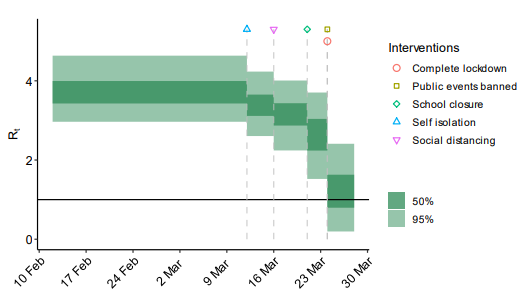
<center>Efecto estimado de las intervenciones del gobierno en el reino unido (fin de marzo)</center>

<b>Cuantas son bastantes pruebas y como afectan a la curva?</b> 

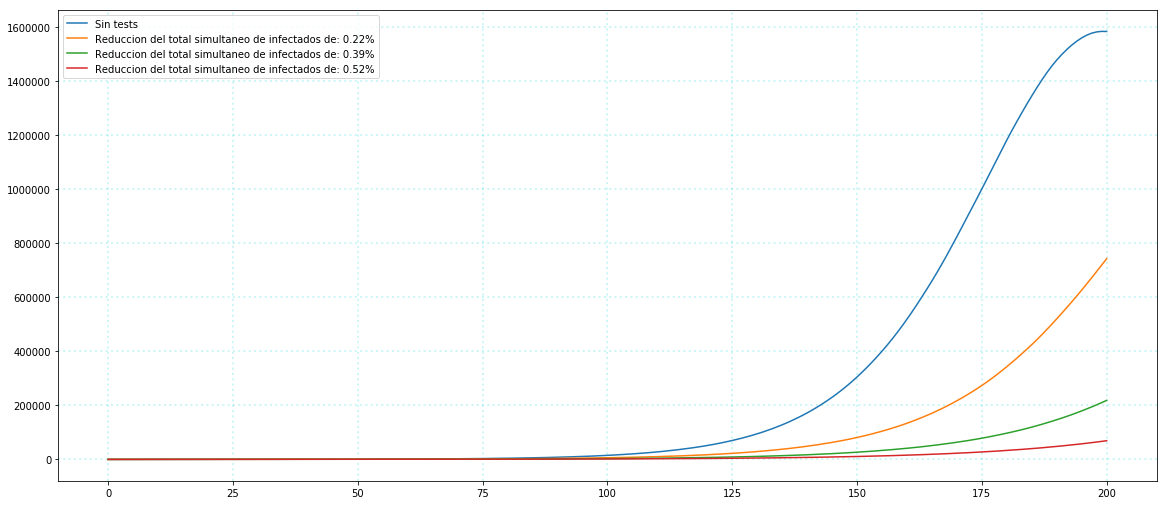

In [38]:
to_day = 200
solutions_x_capped = solutions_x[:to_day]

ax = plot(solutions_x_capped, sol_it[0][:to_day], labels=['Sin tests'])

for _ in range(1, len(solutions)):
    ax.plot(
        solutions_x_capped, 
        sol_it[_][:to_day], 
        label='Reduccion del total simultaneo de infectados de: {:.2f}%'. format(
            1 - max(sol_it[_] / max(sol_it[0]))
        )
    )
    ax.legend(loc='upper left')


# to_day = 80

TODO: Escribir...

In [6]:
days = [23, len(data[0]) - 23]
def naive_fit():
    def sqsum(R_ts):
        solution = run_model(R_ts)
        solution_data = np.array(solution['y'])
        
        return np.sum((solution_data[(3, 5),] - data[(0, 2),]) ** 2)

    return scipy.optimize.minimize(
        sqsum, (2., .2, .4, 1.6), method='TNC', bounds=(
            (1.2, 4.4), (0.01, 0.33), (0.18, 0.6), (1.4, 2.2)
        )
    ).x

R_ts = naive_fit()
R_ts

array([3.73464965, 0.14754054, 0.18      , 1.72694244])

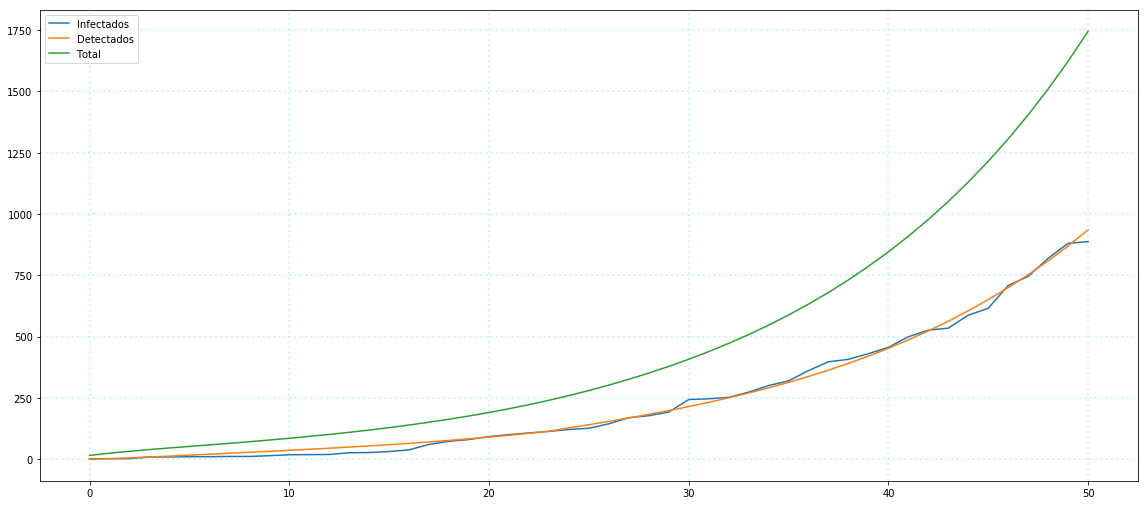

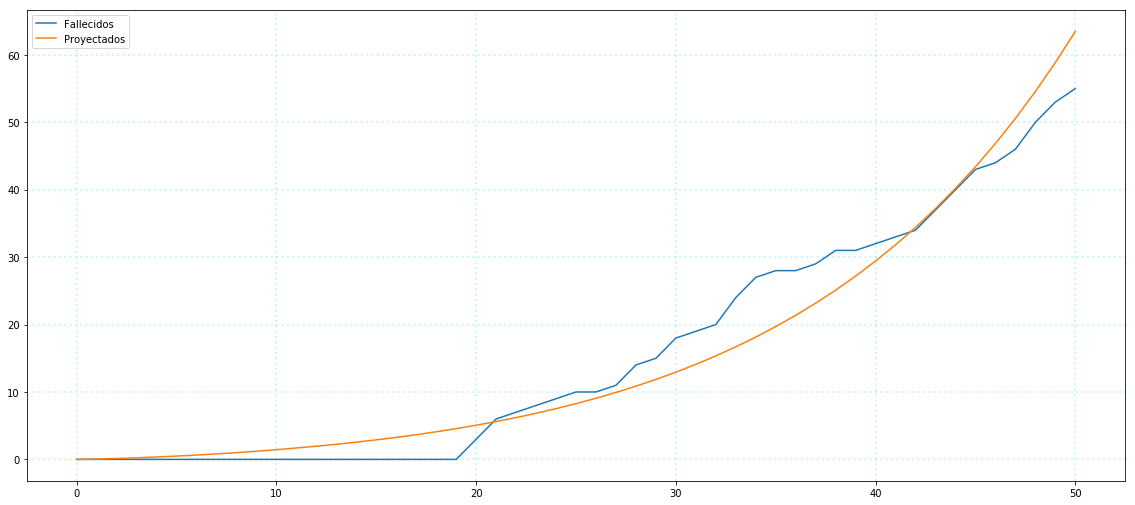

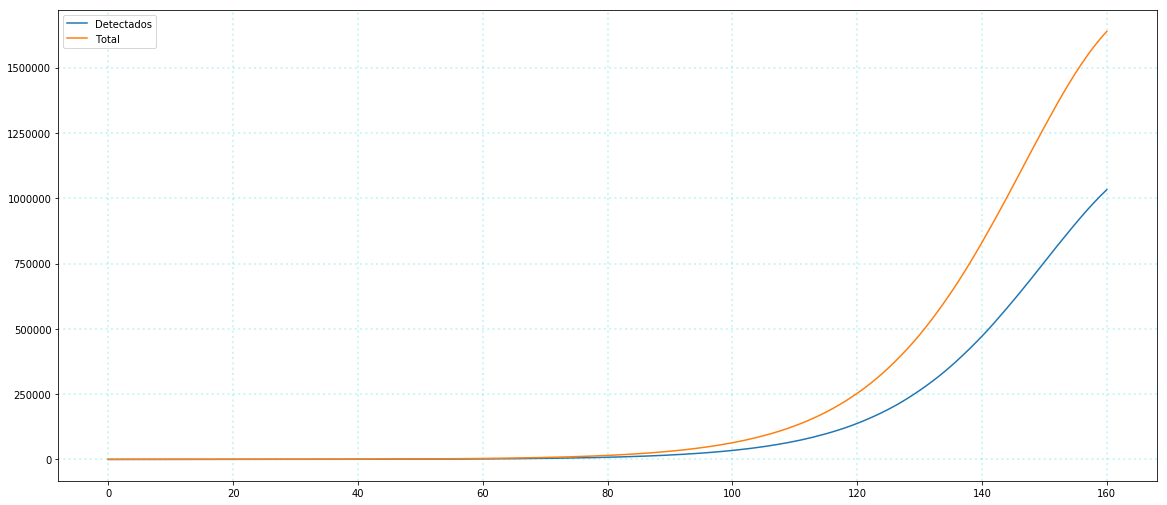

In [7]:
solution = run_model(R_ts)

plot(
    solution['t'], 
    data[0], solution['y'][3], solution['y'][3] + solution['y'][2],
    labels=[
        'Infectados', 'Detectados', 'Total',
    ]
)

plot(
    solution['t'], 
    data[2], solution['y'][5],
    labels=[
        'Fallecidos', 'Proyectados',
    ]
)
days = [12, 11, 160 - 23]
solution = run_model(R_ts)

plot(
    solution['t'], 
     solution['y'][3], solution['y'][3] + solution['y'][2],
    labels=[
        'Detectados', 'Total',
    ]
)

Tremendo problema la regresion ahorita

In [8]:
days = [23, len(data[0]) - 23]
def naive_lmfit():
    params = lmfit.Parameters()
    params.add('R_0', value=2., min=1.2, max=4.4)
    params.add('theta_t0', value=.1, min=.01, max=.24)
    params.add('theta_t1', value=.4, min=.12, max=.6)
    params.add('R_D', value=1.2, min=1., max=2.2)
    
    def sqsum(R_ts):
        solution = run_model(R_ts)
        solution_data = np.array(solution['y'])
        
        return (solution_data[(3, 5),] - data[(0, 2),]) ** 2
    
    return lmfit.minimize(sqsum, params, method='differential_evolution')

R_ts = naive_lmfit()
R_ts

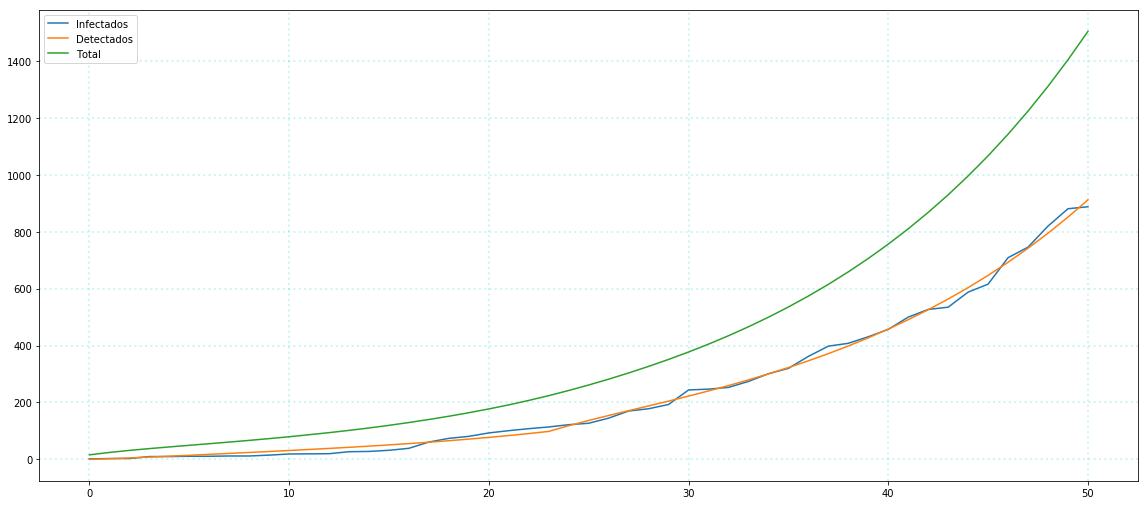

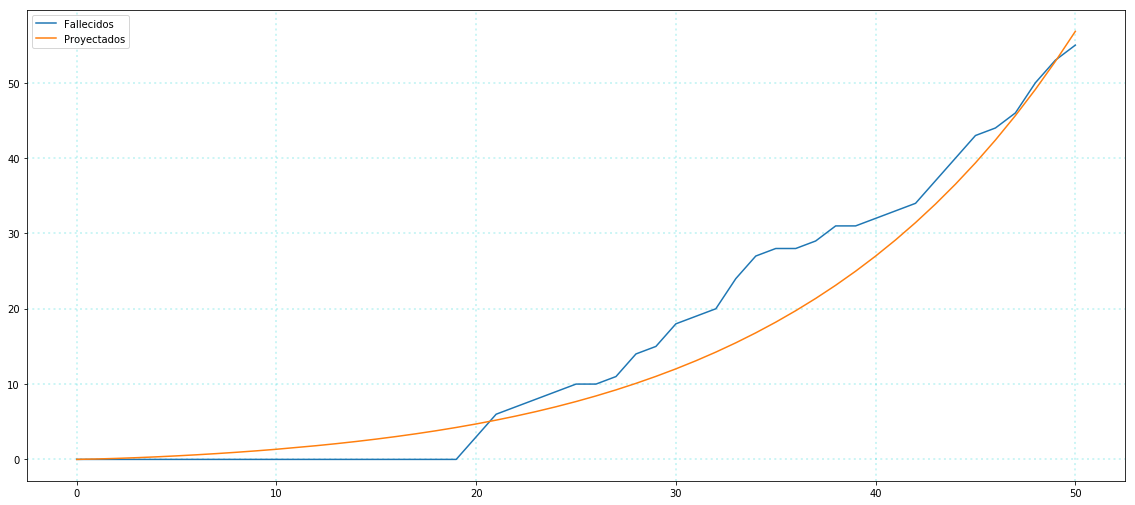

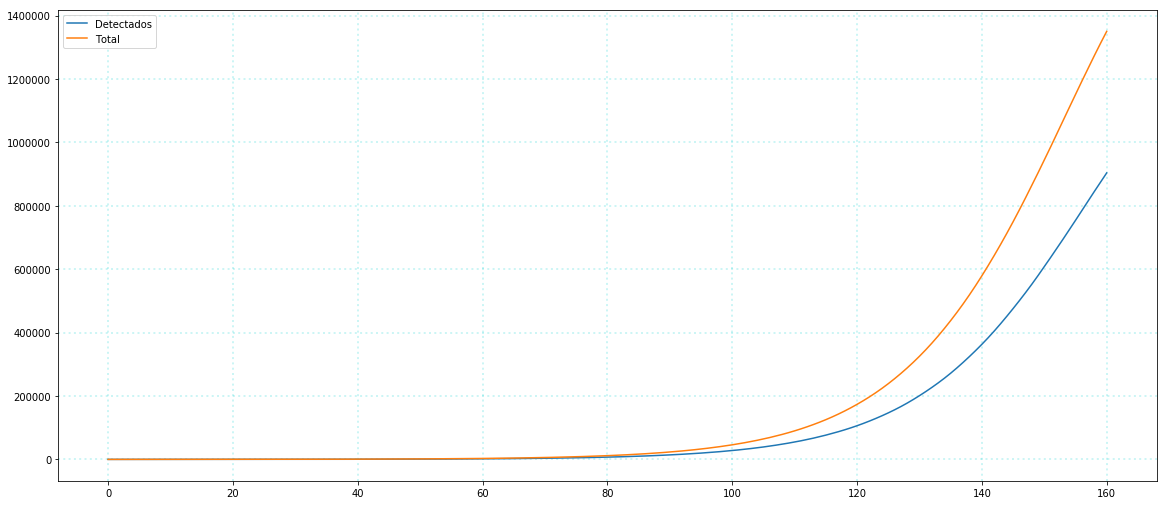

In [9]:
solution = run_model(R_ts.params)

plot(
    solution['t'], 
    data[0], solution['y'][3], solution['y'][3] + solution['y'][2],
    labels=[
        'Infectados', 'Detectados', 'Total',
    ]
)

plot(
    solution['t'], 
    data[2], solution['y'][5],
    labels=[
        'Fallecidos', 'Proyectados',
    ]
)
days = [12, 11, 160 - 23]
solution = run_model(R_ts.params)

plot(
    solution['t'], 
     solution['y'][3], solution['y'][3] + solution['y'][2],
    labels=[
        'Detectados', 'Total',
    ]
)

Notas:
* El efecto de hacer pruebas y aislar a los infectados era obvio y ahora queda claro, no se pudo ver mucho mas, en el uno de los fittings proyecto ~ 1500 casos, 50% mas de los detectados al dia, no tiene mucho sentido.
* Por ahora nada el fitting

Que hacer ahora?
* Como hacer explicito el contact tracing? Por ahora beta_d depende de un R_d que seria la efectividad de aislar al infectado y cuando se lo detecto, pero ese infectado crea una red de contactos que pasan directamente a observacion/aislacion/cuarentena, cuantos contactos ~?